In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (16.0, 8.0)

Populating the interactive namespace from numpy and matplotlib


# Final exercise: a full Monte Carlo example

The length of a gauge block is to be measured by comparison with a reference block of the same nominal length.
The measurand is the difference $\delta L$ between the measured object and the reference block. The mathematical model for the evaluation of the measurand is  
$$ \delta L = L_s + D + d_1 + d_2 - L_s(\delta\alpha(\theta_0 - \Delta)+\alpha_s\delta\theta) - L_{nom} $$

 Quantity | description | distribution 
 :--- |---|:---
 $L_s$ | length of reference block | t-dist with 18 dof, $\mu = 50000623$, $s=25$ 
 $D$ | average comparator value | t-dist with 24 dof, $\mu = 215$, $s=6$ 
 $d_1$ | random errors in comparator measurement | t-dist with 5 dof, $\mu=0$, $s=4$
 $d_2$ | systematic errors in comparator measurement | t-dist with 8 dof, $\mu=0$, $s=7$
 $\alpha_s$ | thermal expansion coefficient of reference | uniform on $[-9.5e-6,13.5e-6]$
 $\theta_0$ | average temperature of measured object | $N(-0.1, 0.2^2)$
 $\Delta$ | cyclic temperature variation | $\mathcal{U}(-0.5, 0.5)$
 $\delta\theta$ | temperature deviation | curvi-linear $ctrap(a=-0.05, b=0.05, u=0.025)$
 $\delta\alpha$ | thermal expansion coeff. deviation | curvi-linear $ctrap(a=-1e-6,b=1e-6,u=0.1e-6)$


Carry out the corresponding estimation of the measurand $\delta L$ and the evaluation of uncertainties using Monte Carlo simulations with adaptive determination of the number of Monte Carlo trials such that a numerical accuracy of $\delta = 0.5$ is achieved at a 99% level of confidence for the estimate and its associated uncertainty. Also calculate the symmetric interval with 95% coverage probalitity for the measurand.

In [2]:
import numpy as np

class ctrap:
    # Model for rectangular distribution with inexactly known endpoints
    # left end point is R(a,c) and right end point is R(d,b) distributed
    def __init__(self,a,b,ua,ub=None):
        if not isinstance(ub,float):
            ub = ua
        self.a = a-ua
        self.b = b+ub
        self.c = a+ua
        self.d = b-ub
    def rvs(self, size=1):
        u = np.random.rand(size)
        v = np.random.rand(size)
        w = np.random.rand(size)
        z1 = self.a + (self.c-self.a)*u
        z2 = self.d + (self.b-self.d)*v
        return z1 + (z2-z1)*w

In [3]:
import scipy.stats as stats

def model(Ls, D, d1, d2, alphas, theta0, Delta, dalpha, dtheta):
    return Ls + D + d1 + d2 - Ls*(dalpha*(theta0-Delta) + alphas*dtheta) - 50000000

Ls = stats.t(18, loc = 50000623, scale = 25)
D  = stats.t(24, loc=215, scale = 6)
d1 = stats.t(5, scale = 4)
d2 = stats.t(8, scale = 7)
alphas = stats.uniform(loc= 9.5e-6, scale = 4e-6)
theta0 = stats.norm(loc=-0.1, scale = 0.2)
Delta = stats.arcsine(loc=-0.5)
dalpha= ctrap(-1e-6, 1e-6, 0.1e-6)
dtheta= ctrap(-0.05, 0.05, 0.025)

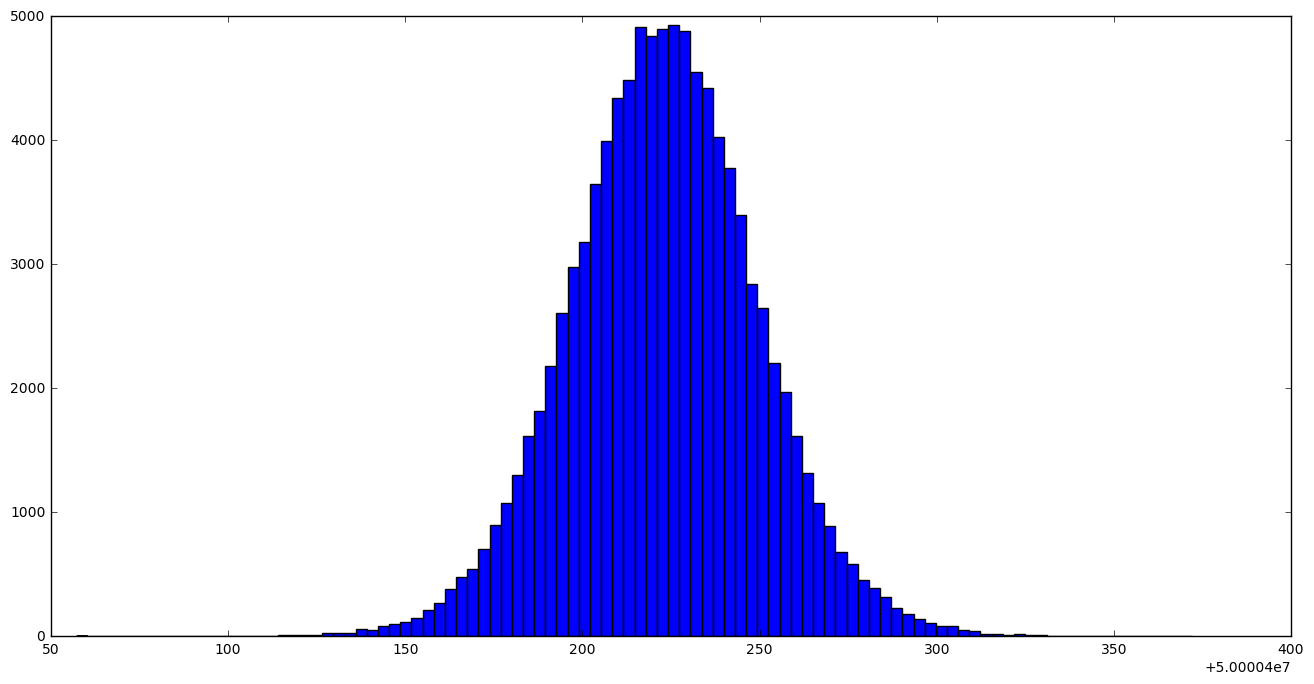

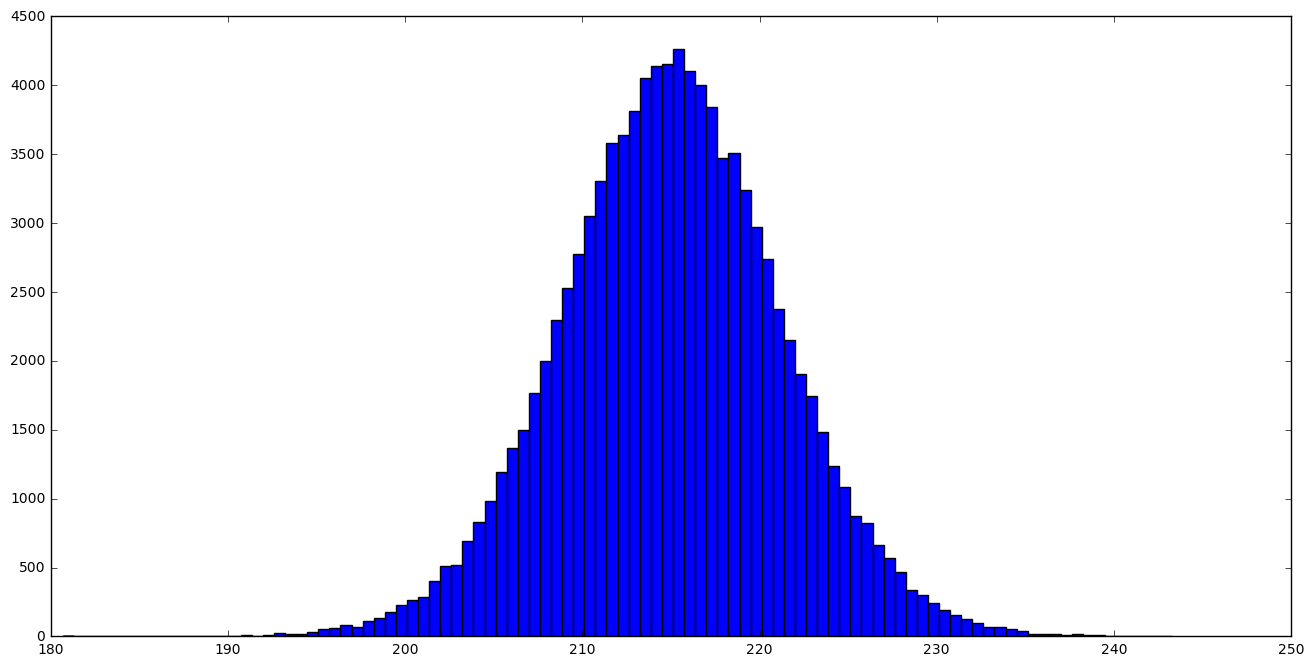

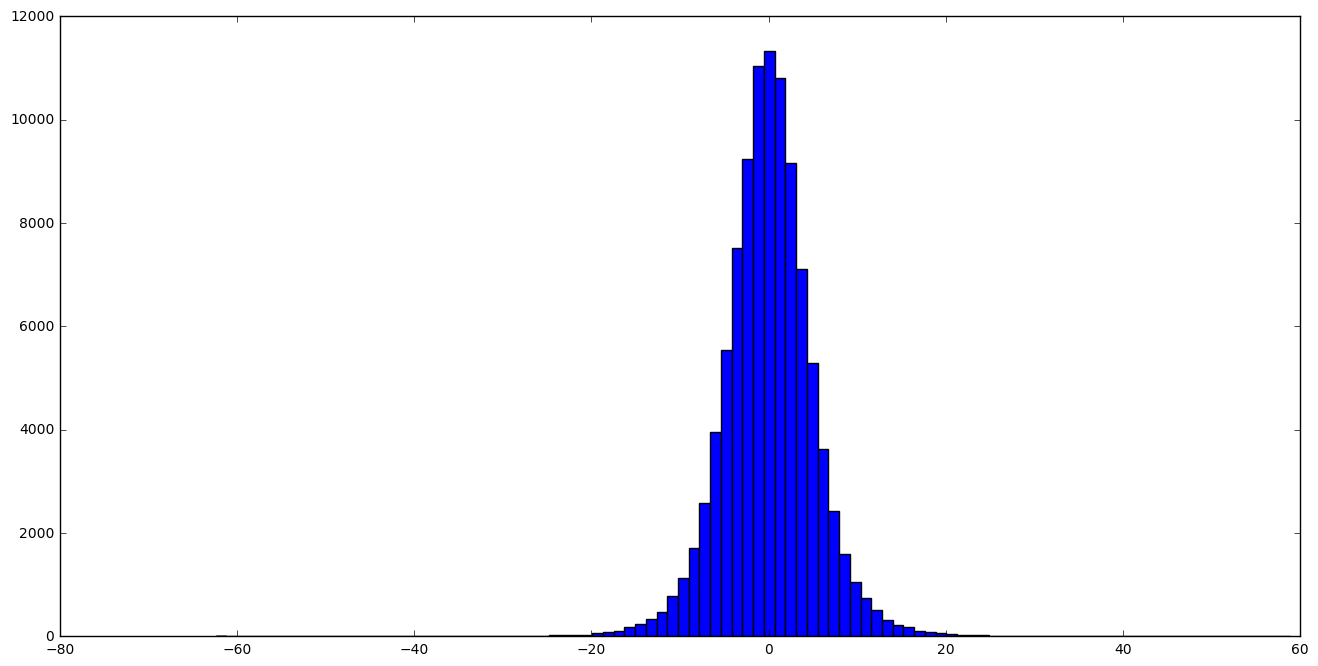

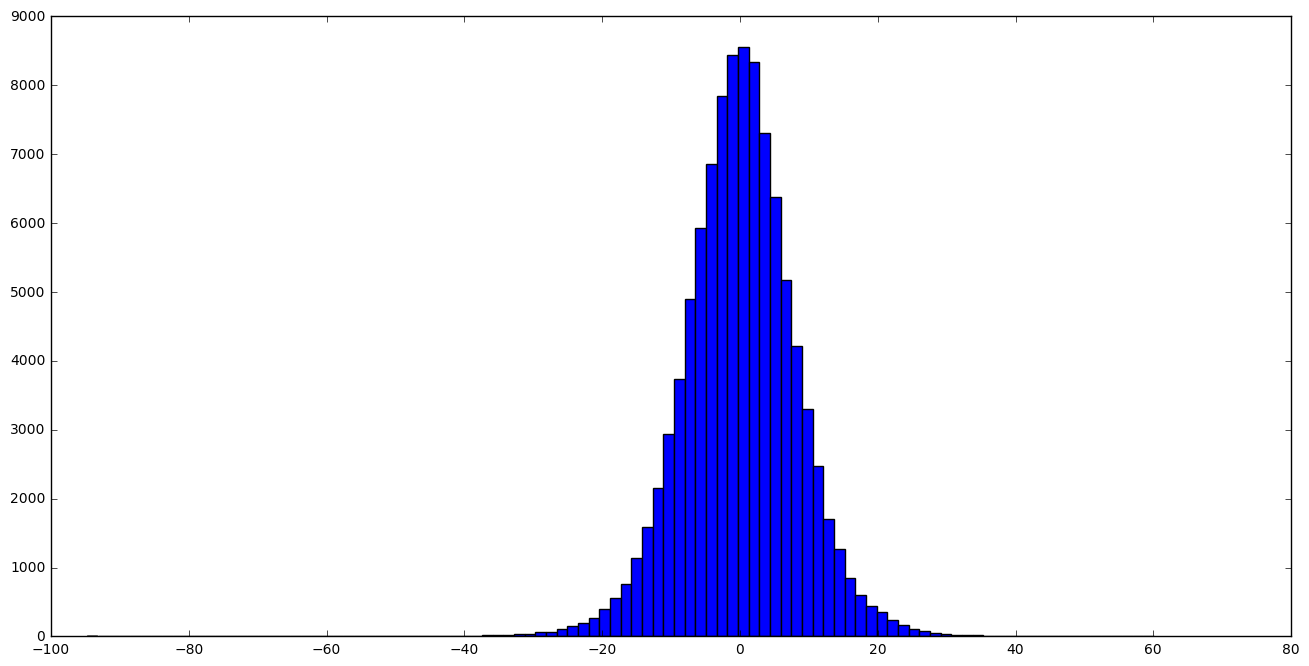

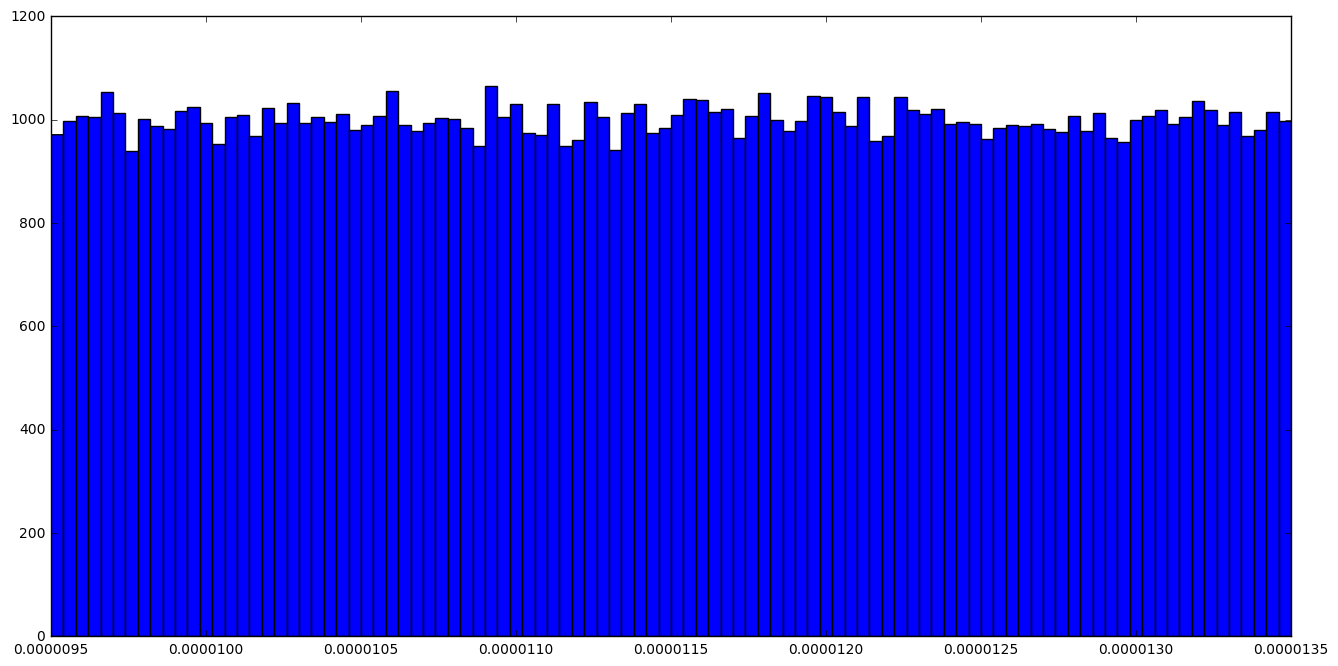

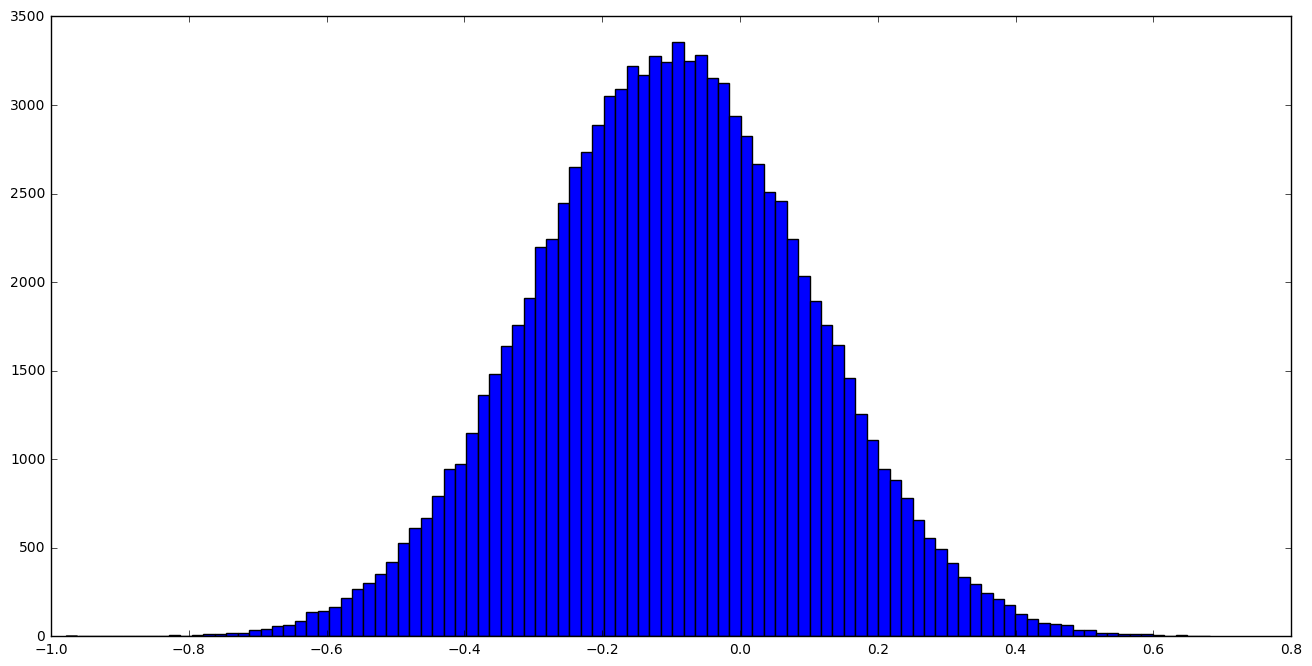

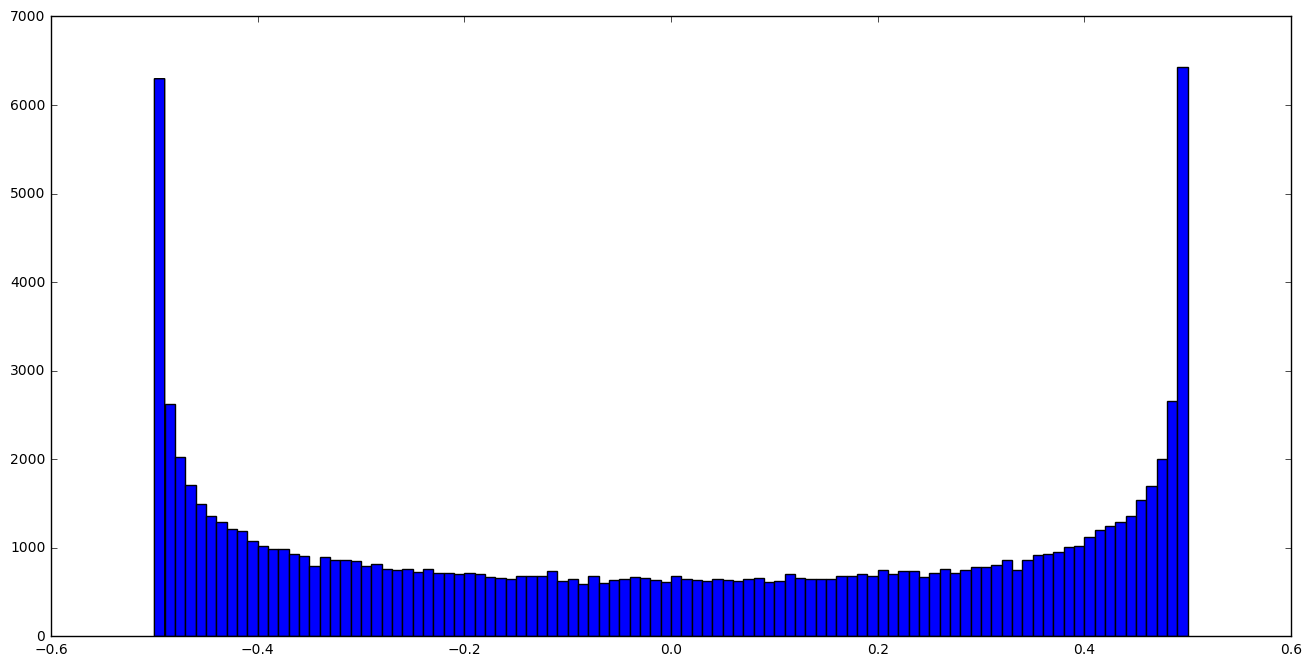

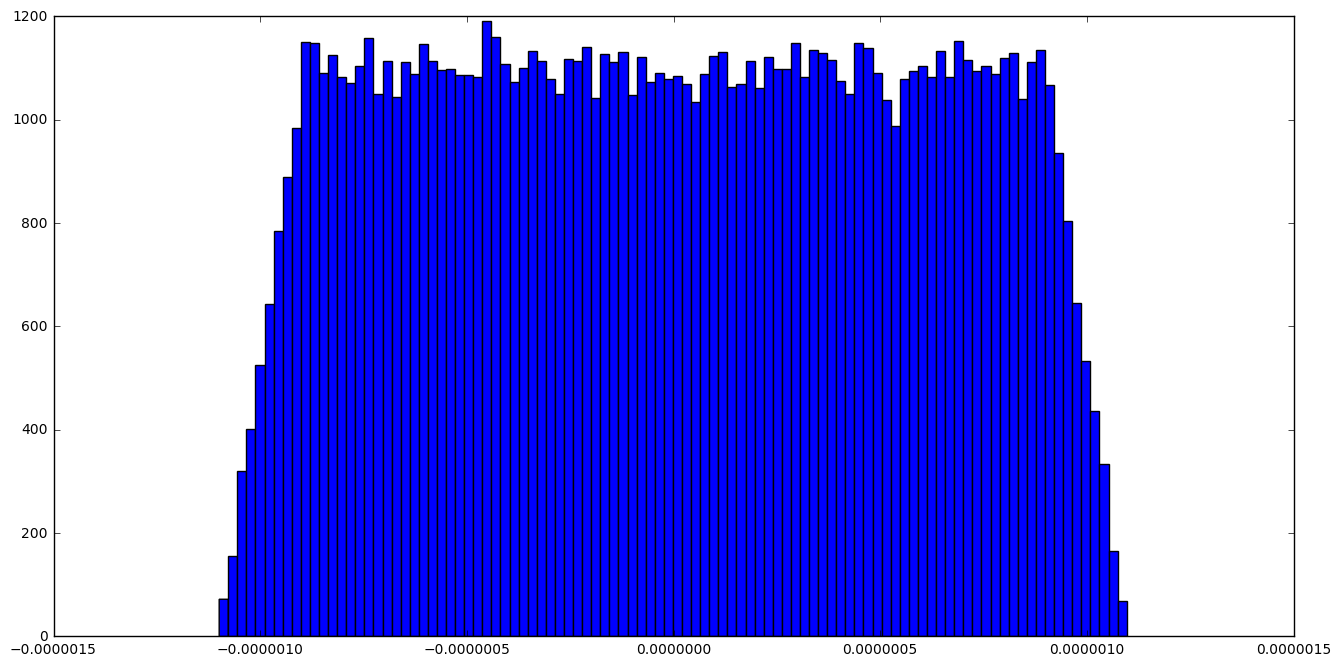

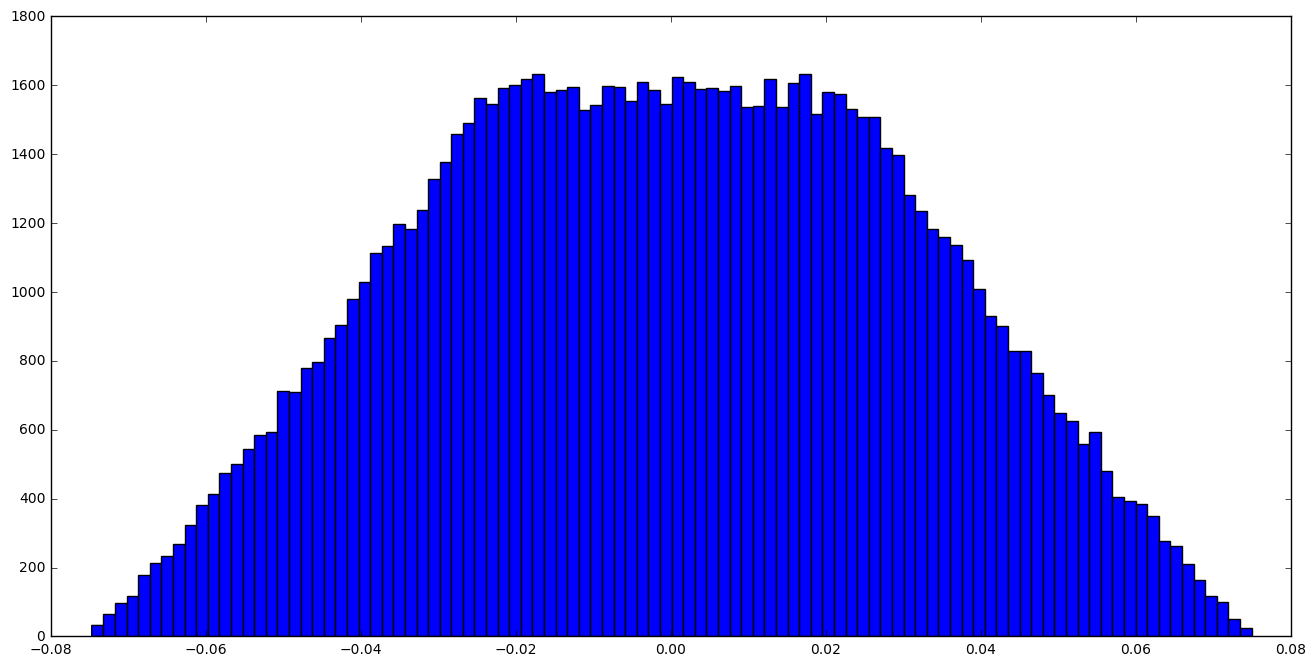

In [4]:
k=1
for dist in [Ls, D, d1, d2, alphas, theta0, Delta, dalpha, dtheta]:
    samples = dist.rvs(100000)
    figure()
    hist(samples, bins = 100);

In [5]:
MCruns = 1000
h1 = 10

delta = 0.5
alpha = 0.01

estimates = zeros(h1)
uncertainties = zeros(h1)
Y = array([])

for k in range(h1):
    MCLs = Ls.rvs(MCruns)
    MCD = D.rvs(MCruns)
    MCd1= d1.rvs(MCruns)
    MCd2= d2.rvs(MCruns)
    MCas= alphas.rvs(MCruns)
    MCt0= theta0.rvs(MCruns)
    MCDl= Delta.rvs(MCruns)
    MCda= dalpha.rvs(MCruns)
    MCdt= dtheta.rvs(MCruns)
    dL = model(MCLs, MCD, MCd1, MCd2, MCas, MCt0, MCDl, MCda, MCdt)
    Y = np.r_[Y, dL]
    estimates[k] = dL.mean()
    uncertainties[k] = dL.std()

std_estimates = estimates.std()
std_uncertainties = uncertainties.std()
tquantile = stats.t(h1-1).ppf(1-alpha/2)
h2_estimate = max( int(std_estimates**2*tquantile**2/delta**2)-h1+1, 0 )
h2_uncertain= max( int(std_uncertainties**2*tquantile**2/delta**2)-h1+1,0 )
h2 = max(h2_estimate, h2_uncertain)
print("The total number of MC trials is %d"%((h1+h2)*MCruns))

estimates = np.r_[estimates, zeros(h2)]
uncertainties = np.r_[uncertainties, zeros(h2)]

for k in range(h1,h1+h2):
    MCLs = Ls.rvs(MCruns)
    MCD = D.rvs(MCruns)
    MCd1= d1.rvs(MCruns)
    MCd2= d2.rvs(MCruns)
    MCas= alphas.rvs(MCruns)
    MCt0= theta0.rvs(MCruns)
    MCDl= Delta.rvs(MCruns)
    MCda= dalpha.rvs(MCruns)
    MCdt= dtheta.rvs(MCruns)
    dL = model(MCLs, MCD, MCd1, MCd2, MCas, MCt0, MCDl, MCda, MCdt)
    Y = np.r_[Y, dL]
    estimates[k] = dL.mean()
    uncertainties[k] = dL.std()



The total number of MC trials is 34000


In [6]:
print("estimate of measurand %d"%estimates.mean())
print("associated uncertainty %d" %uncertainties.mean())

# calculation of interval
P = 0.99
M = (h1+h2)*MCruns
q  = int(M*P)
r  = int(0.5*(M-q))
Ys = sort(Y)
ylow = Ys[r]
yhigh = Ys[r+q]

print("95%% coverage interval is [%d, %d]"%(ylow, yhigh))

estimate of measurand 838
associated uncertainty 36
95% coverage interval is [746, 934]
